<a href="https://colab.research.google.com/github/chwdoit/BigData/blob/main/%EB%A1%9C%EB%98%90_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 로또 번호 예측은 불가능하다

> 유튜브 [빵형의 개발도상국](https://www.youtube.com/@bbanghyong)

### Reference

- [로또 추천이 말도 안되는 이유 (feat data)](https://gils-lab.tistory.com/m/123)
- [로또 가 예측이 의미 없는 이유](https://serienzdairen.tistory.com/80)
- [로또 번호를 예측하는 사람에게 하고 싶은 이야기](https://m.blog.naver.com/kostat_giro/220885615989)
- [카이제곱 적합도 검정(feat. m&m) - Goodness of fit test](https://minitistics.tistory.com/17)

In [ ]:
import pandas as pd
import json
from tqdm import tqdm
from urllib.request import urlopen
import matplotlib.pyplot as plt
from scipy.stats import chisquare
import numpy as np
import pytz
from datetime import datetime

seoul_timezone = pytz.timezone('Asia/Seoul')
now_in_seoul = datetime.now(seoul_timezone)
now_in_seoul.strftime("%Y-%m-%d %H:%M:%S")

'2024-03-18 19:12:54'

## 데이터 수집

- totSellamnt: 누적금액
- returnValue: 실행결과
- drwNoDate: 추첨 일자
- firstWinamnt: 1등 당첨금
- firstPrzwnerCo: 1등 당첨 인원
- bnusNo:보너스 번호
- drwNo: 회차
- drwtNo1~6: 당첨번호 숫자

In [ ]:
df = pd.DataFrame([], columns=["totSellamnt", "returnValue", "drwNoDate", "firstWinamnt", "firstPrzwnerCo", "bnusNo", "drwNo", "drwtNo1", "drwtNo2", "drwtNo3", "drwtNo4", "drwtNo5", "drwtNo6", "firstAccumamnt"])

df

,totSellamnt,returnValue,drwNoDate,firstWinamnt,firstPrzwnerCo,bnusNo,drwNo,drwtNo1,drwtNo2,drwtNo3,drwtNo4,drwtNo5,drwtNo6,firstAccumamnt


In [ ]:
n = 1 #회차

url = f"http://www.dhlottery.co.kr/common.do?method=getLottoNumber&drwNo={n}"

result_data = urlopen(url)
result = result_data.read()
data = json.loads(result)

df_sub = pd.DataFrame.from_dict(data, orient="index")
df_sub = df_sub.transpose()

df_sub

,totSellamnt,returnValue,drwNoDate,firstWinamnt,drwtNo6,drwtNo4,firstPrzwnerCo,drwtNo5,bnusNo,firstAccumamnt,drwNo,drwtNo2,drwtNo3,drwtNo1
0,3681782000,success,2002-12-07,0,40,33,0,37,16,863604600,1,23,29,10


In [ ]:
end = 1109

for n in tqdm(range(1, end+1)):
    url = f"http://www.dhlottery.co.kr/common.do?method=getLottoNumber&drwNo={n}"

    result_data = urlopen(url)
    result = result_data.read()
    data = json.loads(result)

    df_sub = pd.DataFrame.from_dict(data, orient="index")
    df_sub = df_sub.transpose()

    df = pd.concat([df, df_sub], ignore_index=True)

df.tail()

 16%|█▌        | 172/1109 [02:44<14:53,  1.05it/s]


KeyboardInterrupt: 

In [ ]:
df.to_csv(f"lotto_{end}.csv", index=False)

## 데이터 로드

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/kairess/toy-datasets/master/lotto_1109.csv")

df.head()

,totSellamnt,returnValue,drwNoDate,firstWinamnt,firstPrzwnerCo,bnusNo,drwNo,drwtNo1,drwtNo2,drwtNo3,drwtNo4,drwtNo5,drwtNo6,firstAccumamnt
0,3681782000,success,2002-12-07,0,0,16,1,10,23,29,33,37,40,863604600
1,4904274000,success,2002-12-14,2002006800,1,2,2,9,13,21,25,32,42,0
2,4729342000,success,2002-12-21,2000000000,1,30,3,11,16,19,21,27,31,0
3,5271464000,success,2002-12-28,0,0,2,4,14,27,30,31,40,42,1267147200
4,6277102000,success,2003-01-04,0,0,3,5,16,24,29,40,41,42,3041094900


## 숫자 출현 빈도 시각화

In [ ]:
df = df[["drwtNo1", "drwtNo2", "drwtNo3", "drwtNo4", "drwtNo5", "drwtNo6"]]
win_numbers = df.apply(lambda x:list(x), axis=1)

win_numbers.head()

0    [10, 23, 29, 33, 37, 40]
1     [9, 13, 21, 25, 32, 42]
2    [11, 16, 19, 21, 27, 31]
3    [14, 27, 30, 31, 40, 42]
4    [16, 24, 29, 40, 41, 42]
dtype: object

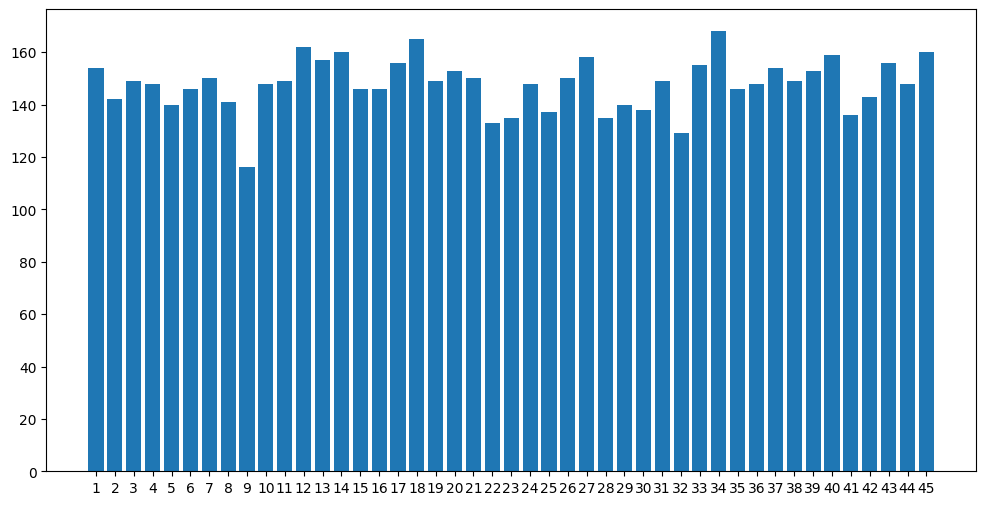

In [ ]:
occur_dist = [win_numbers.apply(lambda x:v in x).sum() for v in range(1, 46)]

plt.figure(figsize=(12, 6))
plt.bar(range(45), occur_dist)
plt.xticks(range(45), range(1, 46))
plt.show()

## 카이제곱 적합도 검정

p_value가 1에 가깝다 = 특별히 자주 나오는 번호는 없다

- [카이제곱 적합도 검정(feat. m&m) - Goodness of fit test](https://minitistics.tistory.com/17)

In [ ]:
expected = [np.mean(occur_dist)] * 45

chi_square_test_statistic, p_value = chisquare(occur_dist, expected)

p_value

0.9544336016950442

## 회귀 분석?

In [ ]:
from sklearn.linear_model import LinearRegression

def regression_analysis_per_number(winning_numbers):
    """각 로또 번호에 대해 독립적인 회귀 분석을 실시합니다."""
    models = []

    # 회차 번호를 독립 변수 X로 사용
    X = np.arange(1, len(winning_numbers) + 1).reshape(-1, 1)

    # 각 번호(1~6번)에 대해 별도의 모델을 학습
    for number_position in range(6):
        y = np.array([numbers[number_position] for numbers in winning_numbers])
        model = LinearRegression()
        model.fit(X, y) # 1 # [10, 23, 29, 33, 37, 40]
        models.append(model)

    return models

# 각 번호별 모델 학습
models_per_number = regression_analysis_per_number(win_numbers)

for i, model in enumerate(models_per_number):
    coef = model.coef_[0]  # 모델의 기울기
    intercept = model.intercept_  # y절편

    print(f"{i+1}: {coef:.5f}, {intercept:.5f}")

1: 0.00053, 6.41794
2: 0.00047, 12.85834
3: 0.00000, 19.99637
4: 0.00019, 26.18762
5: 0.00054, 32.58483
6: 0.00067, 39.18585


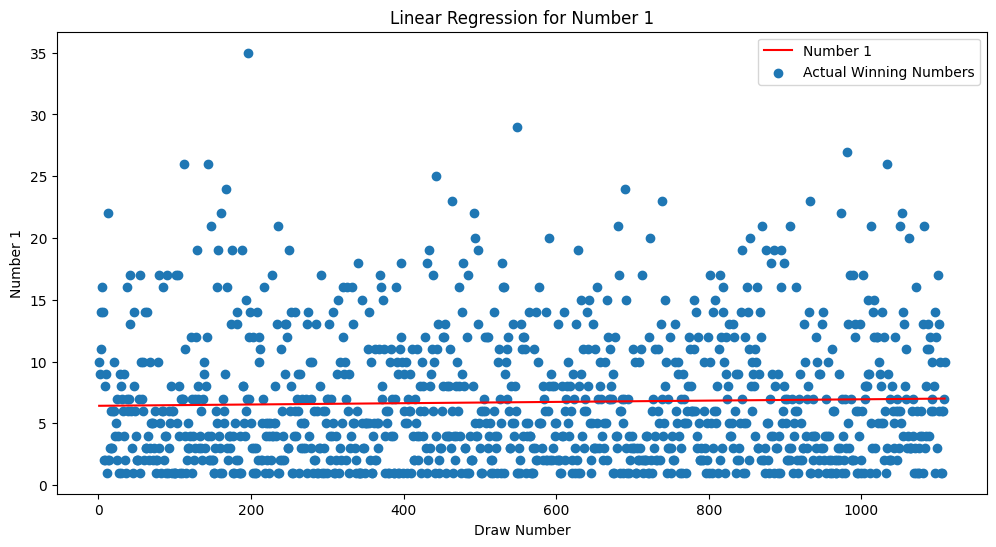

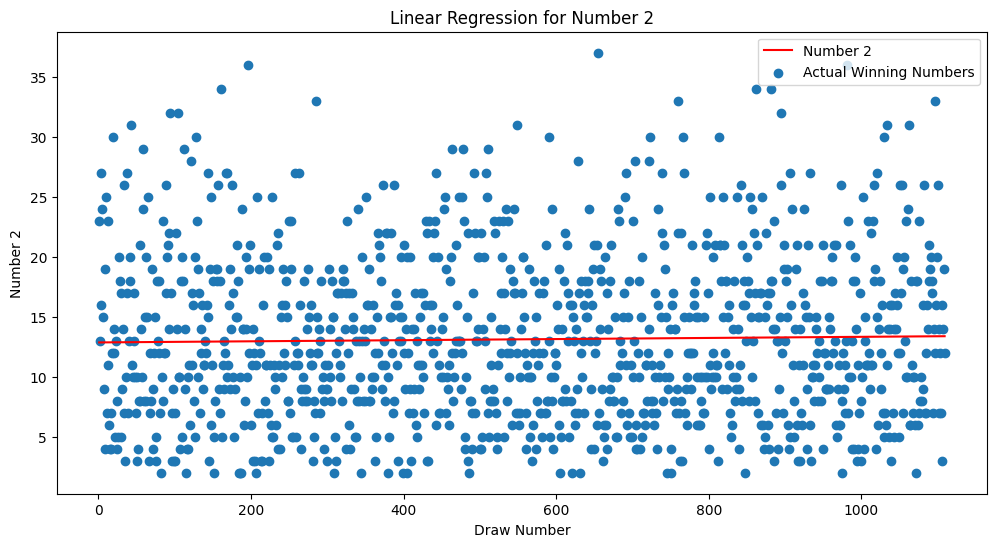

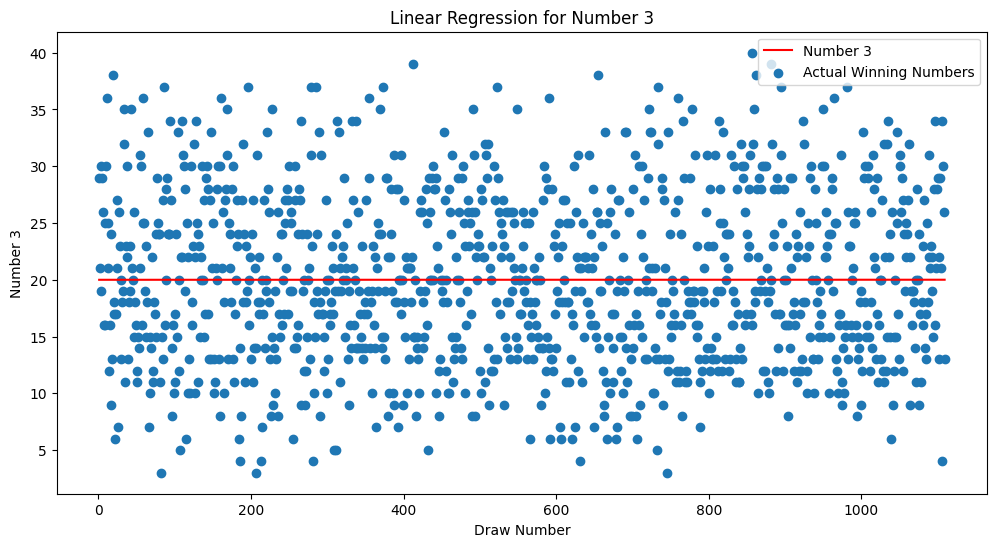

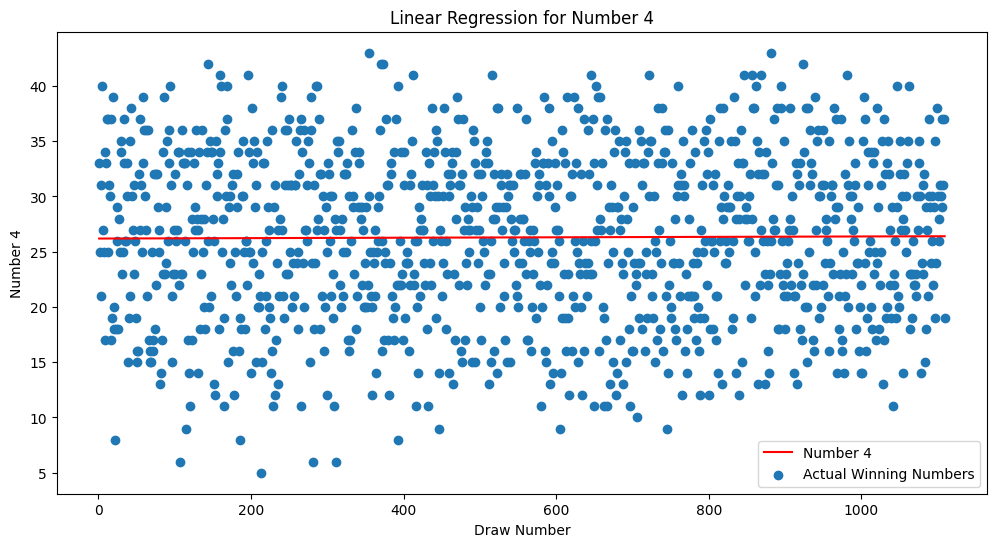

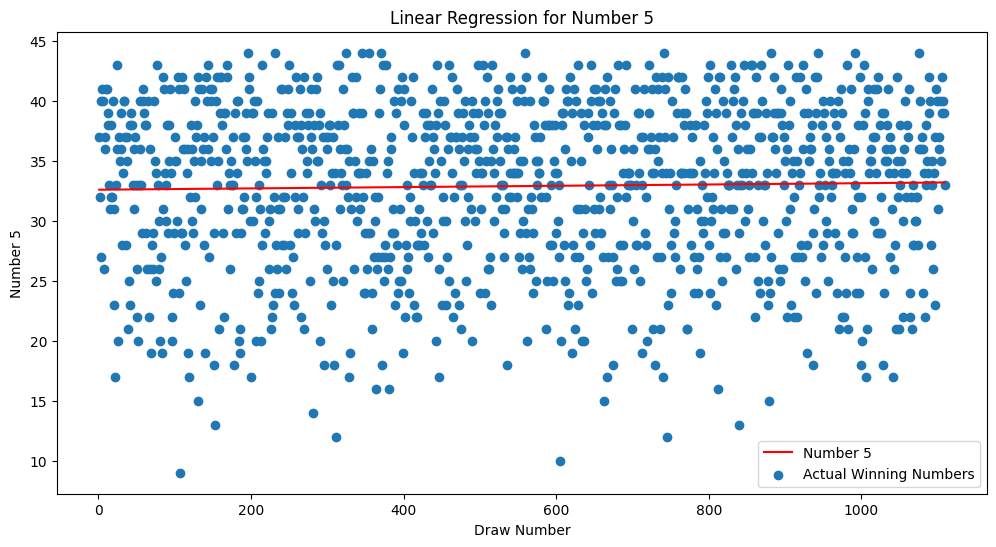

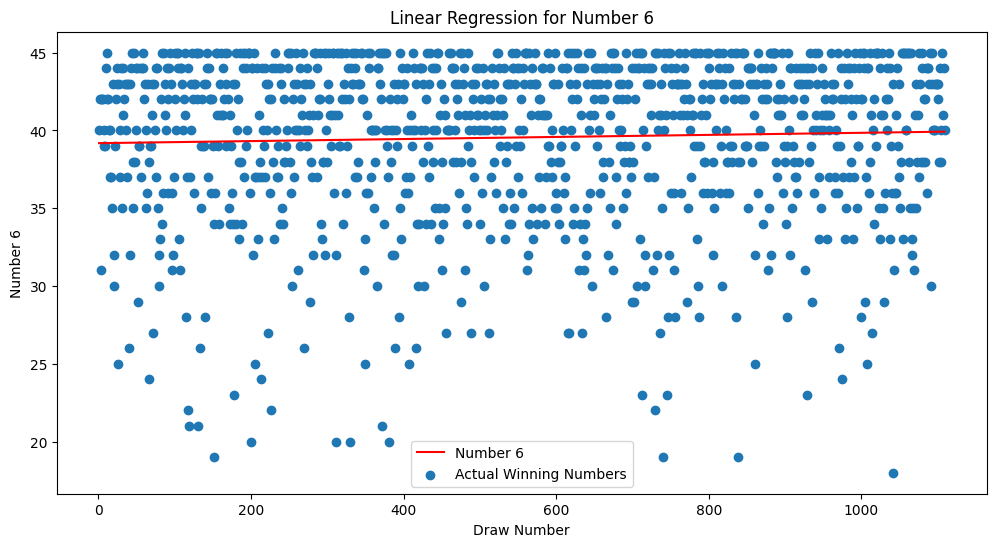

In [ ]:
for i, model in enumerate(models_per_number):
    coef = model.coef_[0]  # 모델의 기울기
    intercept = model.intercept_  # y절편

    # 회차 번호를 독립 변수 X로 사용
    X = np.arange(1, len(win_numbers) + 1).reshape(-1, 1)

    # 예측 값 계산
    y_pred = model.predict(X)

    # 그래프 그리기
    plt.figure(figsize=(12, 6))
    plt.plot(X, y_pred, label=f"Number {i+1}", color="red")

    # 실제 당첨 번호를 점으로 표시
    plt.scatter(X, [numbers[i] for numbers in win_numbers], label="Actual Winning Numbers")

    plt.xlabel("Draw Number")
    plt.ylabel(f"Number {i+1}")
    plt.title(f"Linear Regression for Number {i+1}")
    plt.legend()
    plt.show()

In [ ]:
n = 1110

prediction = []

for i, model in enumerate(models_per_number):
    y = model.predict(np.array([n]).reshape(-1, 1))
    prediction.append(y.item())

print(prediction)

[7.001359080447798, 13.376105575322354, 20.001822958205427, 26.39668872663114, 33.187933969849574, 39.925058513703114]


In [ ]:
print("올림:", np.ceil(prediction).astype(int))
print("반올림:", np.round(prediction).astype(int))
print("내림:", np.floor(prediction).astype(int))

올림: [ 8 14 21 27 34 40]
반올림: [ 7 13 20 26 33 40]
내림: [ 7 13 20 26 33 39]


## 출현 빈도에 따른 가중치 계산

In [ ]:
# 3. 가중치 조정
def adjust_weights(frequency):
    """번호 출현 빈도에 따라 가중치를 조정합니다."""
    weights = frequency / frequency.sum()
    return weights

weights = adjust_weights(np.array(occur_dist))

weights

array([0.02314397, 0.02134055, 0.02239255, 0.02224226, 0.02103998,
       0.02194169, 0.02254283, 0.02119026, 0.01743312, 0.02224226,
       0.02239255, 0.02434626, 0.02359483, 0.02404569, 0.02194169,
       0.02194169, 0.02344454, 0.02479711, 0.02239255, 0.02299369,
       0.02254283, 0.01998798, 0.02028855, 0.02224226, 0.02058912,
       0.02254283, 0.02374512, 0.02028855, 0.02103998, 0.0207394 ,
       0.02239255, 0.01938683, 0.02329426, 0.02524797, 0.02194169,
       0.02224226, 0.02314397, 0.02239255, 0.02299369, 0.0238954 ,
       0.02043883, 0.02149083, 0.02344454, 0.02224226, 0.02404569])

In [ ]:
import random

# 4. 번호 조합 생성
def generate_weighted_combination(weights):
    """가중치를 고려하여 번호 조합을 생성합니다."""
    numbers = list(range(1, 46))
    chosen_numbers = random.choices(numbers, weights=weights, k=6)
    chosen_numbers.sort()
    return chosen_numbers

generate_weighted_combination(weights)

[3, 18, 26, 30, 32, 40]

## 구매

- 챗GPT: [2, 6, 16, 22, 30, 32]

### 회귀 모델
- 올림: [ 8 14 21 27 34 40]
- 반올림: [ 7 13 20 26 33 40]
- 내림: [ 7 13 20 26 33 39]

### 출현 빈도

- [4, 8, 17, 26, 29, 43]